***Importing Libraries***

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


***Loading the training and testing MNIST dataset***

In [83]:
# Load train and test datasets
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')
train.head(), test.head()

(   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
 0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
 1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
 2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
 3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
 4      9    0    0    0    0    0    0    0    0    0  ...      0      0   
 
    28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
 0      0      0      0      0      0      0      0      0  
 1      0      0      0      0      0      0      0      0  
 2      0      0      0      0      0      0      0      0  
 3      0      0      0      0      0      0      0      0  
 4      0      0      0      0      0      0      0      0  
 
 [5 rows x 785 columns],
    label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
 0      7    0    0    0    0    0    0    0    0    0  ...      0

In [84]:
# Convert Dataframe into format ready for training
def createImageData(raw: pd.DataFrame):
    y = raw['label'].values
    y.resize(y.shape[0],1)
    x = raw[[i for i in raw.columns if i != 'label']].values
    x = x.reshape([-1,1, 28, 28])
    y = y.astype(int).reshape(-1)
    x = x.astype(float)
    return x, y

***Splitting the training dataset to training and validation***

In [85]:
x_train, y_train = createImageData(train)
x_test, y_test = createImageData(test)

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((48000, 1, 28, 28),
 (48000,),
 (12000, 1, 28, 28),
 (12000,),
 (10000, 1, 28, 28),
 (10000,))

***Convert data to PyTorch tensors***

In [86]:
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), 'constant')  
x_val = np.pad(x_val, ((0, 0), (0, 0), (2, 2), (2, 2)), 'constant')      
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), 'constant')    

print("Train Updated Image Shape:", x_train[0].shape) 
print("Validation Updated Image Shape:", x_val[0].shape)
print("Test Updated Image Shape:", x_test[0].shape) 

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


print("Shape of x_train:", x_train.shape) 
print("Shape of x_val:", x_val.shape)      
print("Shape of x_test:", x_test.shape)   
print("Training Set:   {} samples".format(len(x_train)))
print("Validation Set: {} samples".format(len(x_val)))
print("Test Set:       {} samples".format(len(x_test)))

Train Updated Image Shape: (1, 32, 32)
Validation Updated Image Shape: (1, 32, 32)
Test Updated Image Shape: (1, 32, 32)
Shape of x_train: torch.Size([48000, 1, 32, 32])
Shape of x_val: torch.Size([12000, 1, 32, 32])
Shape of x_test: torch.Size([10000, 1, 32, 32])
Training Set:   48000 samples
Validation Set: 12000 samples
Test Set:       10000 samples


tensor(3)


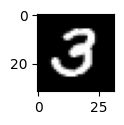

In [87]:
# Printing a Sample data
index = random.randint(0, len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

***Lenet5 Architecture implemetation using Pytorch***

In [88]:
# Define LeNet-5 architecture model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.average1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.average2 = nn.AvgPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1)
        
        self.fc1 = nn.Linear(120 *2 * 2, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, train_data):
        train_data = train_data.view(-1, 1, 32, 32)
        train_data = torch.tanh(self.conv1(train_data))
        train_data = self.average1(train_data)
        train_data = torch.tanh(self.conv2(train_data))
        train_data = self.average2(train_data)
        train_data = torch.tanh(self.conv3(train_data))
        train_data = train_data.view(train_data.size(0), -1)
        train_data = torch.tanh(self.fc1(train_data))
        train_data = torch.softmax(self.fc2(train_data),dim=1)
        return train_data

***Model Initialization***

In [89]:
lenet_model = LeNet5().to(device)
loss_criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

***Accuracy calculation function***

In [90]:
def cal_accuracy(eval_model, x_data, y_data):
    eval_model.eval()
    with torch.no_grad():
        outputs = eval_model(x_data)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_data).float().mean()
    return accuracy.item() * 100

***Model training***

In [91]:
def train_lenet_model(model, train_data, train_labels, val_data, val_labels, epochs=10, segment_size=64):
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []

    for epoch in range(1, epochs + 1):
        # Shuffle the training data and labels at the start of each epoch
        train_data, train_labels = shuffle(train_data, train_labels)

        model.train()
        epoch_loss = 0.0

        for i in range(0, train_data.size(0), segment_size):
            segment_train_data = train_data[i:i + segment_size]
            segment_train_labels = train_labels[i:i + segment_size]
            optimizer.zero_grad()
            segment_outputs = model(segment_train_data)
            segment_loss = loss_criteria(segment_outputs, segment_train_labels)
            segment_loss.backward()
            optimizer.step()
            epoch_loss += segment_loss.item()

        model.eval()
        with torch.no_grad():
            val_outputs = lenet_model(x_val)
            value_loss = loss_criteria(val_outputs, y_val)
            train_loss.append(epoch_loss / len(x_train))
            val_loss.append(value_loss.item())

            train_acc_value = cal_accuracy(model, train_data, train_labels)
            vali_accuracy = cal_accuracy(model, val_data, val_labels)
            train_accuracy.append(train_acc_value)
            val_accuracy.append(vali_accuracy)

        print(f"Epoch {epoch}/{epochs} --- Train Accuracy: {train_acc_value:.2f}% --- Validation Accuracy: {vali_accuracy:.2f}%")
    return train_loss, val_loss, train_accuracy, val_accuracy

In [92]:
train_losses, val_losses,train_accuracies, val_accuracies  = train_lenet_model(lenet_model, x_train, y_train, x_val, y_val, epochs=10)

Epoch 1/10 --- Train Accuracy: 94.98% --- Validation Accuracy: 94.93%
Epoch 2/10 --- Train Accuracy: 96.52% --- Validation Accuracy: 96.36%
Epoch 3/10 --- Train Accuracy: 97.72% --- Validation Accuracy: 97.35%
Epoch 4/10 --- Train Accuracy: 97.90% --- Validation Accuracy: 97.48%
Epoch 5/10 --- Train Accuracy: 98.40% --- Validation Accuracy: 97.91%
Epoch 6/10 --- Train Accuracy: 98.58% --- Validation Accuracy: 98.01%
Epoch 7/10 --- Train Accuracy: 98.48% --- Validation Accuracy: 97.74%
Epoch 8/10 --- Train Accuracy: 98.59% --- Validation Accuracy: 97.99%
Epoch 9/10 --- Train Accuracy: 98.95% --- Validation Accuracy: 98.34%
Epoch 10/10 --- Train Accuracy: 99.06% --- Validation Accuracy: 98.23%


***Testing the model using the test dataset***

In [93]:
test_accuracy = cal_accuracy(lenet_model, x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.41%


***Visualization for the Training and Validation Accuracies for 10 Epochs***

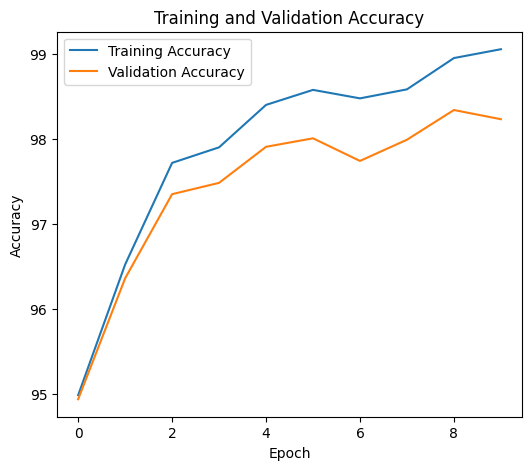

In [94]:
plt.figure(figsize=(6, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

***Confusion Matrix generation***

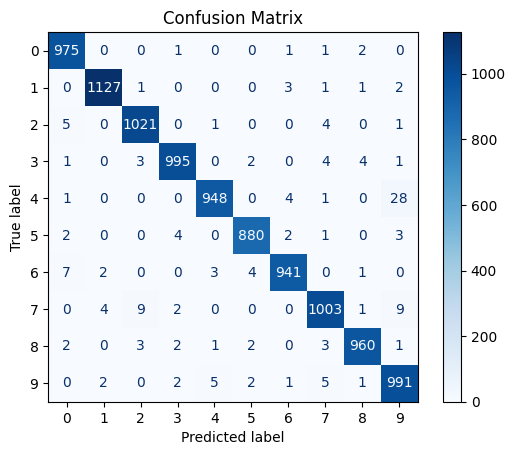

In [95]:
# Get the model predictions for the test data
def get_predictions(eval_model, test_data):
    eval_model.eval()
    with torch.no_grad():
        outputs = eval_model(test_data)
        _, predicted_labels = torch.max(outputs, 1)
    return predicted_labels

# Compute the confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = get_predictions(model, x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
plot_confusion_matrix(lenet_model, x_test, y_test)